In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install librosa numpy matplotlib pydub audiomentations pySmartDL 

In [ ]:
import librosa
import librosa.display # for waveplots, spectograms, etc
import IPython.display as ipd # for playing files within pythonimport numpy as np
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
SAMPLE_RATE = 16000
AUDIO_WINDOW = 1.0 #seconds
AUDIO_LENGTH = int(AUDIO_WINDOW * SAMPLE_RATE)

In [ ]:
import base64
from os import system
from time import sleep

def create_onedrive_directdownload (onedrive_link):
    data_bytes64 = base64.b64encode(bytes(onedrive_link, 'utf-8'))
    data_bytes64_String = data_bytes64.decode('utf-8').replace('/','_').replace('+','-').rstrip("=")
    resultUrl = f"https://api.onedrive.com/v1.0/shares/u!{data_bytes64_String}/root/content"
    return resultUrl

dataset_url = create_onedrive_directdownload("https://1drv.ms/u/s!AuXsUYf_hDUcgq4xD30EZ1Xanf6uhw?e=sv9u8e")
noise_url = create_onedrive_directdownload("https://1drv.ms/u/s!AuXsUYf_hDUcgq57tQZxYjXmoYHSVw?e=a6ZLW8")

from pySmartDL import SmartDL # or ‘~/Downloads/’ on linux

for i in range(3):
  try:
    obj = SmartDL(dataset_url, "/content/dataset_format_fixed.zip") 
    print(obj.start())
    break
  except :
    sleep(0.5)

for i in range(3):
  try:
    obj = SmartDL(noise_url, "/content/noise_format_fixed.zip")
    obj.start()
  except :
    sleep(0.5)

[*] 0 bytes / 344.0 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 344.0 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 344.0 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 344.0 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 344.0 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 344.0 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 344.0 MB @ 0 bytes/s [------------------] [0.0%, 0s left]   

In [ ]:
!unzip -qq dataset_format_fixed.zip
!unzip -qq noise_format_fixed.zip
!rm *.zip

In [ ]:
import random
import numpy as np
import soundfile as sf

def randomCrop(x:np.array,length=AUDIO_LENGTH)->np.array :
    assert(x.shape[0]>length)
    frontBits = random.randint(0,x.shape[0]-length) 
    return x[frontBits:frontBits+length]

def addPadding(x:np.array,length=AUDIO_LENGTH)->np.array :
    assert(x.shape[0]<length)
    bitCountToBeAdded = length - x.shape[0]
    frontBits = random.randint(0,bitCountToBeAdded)
    #print(frontBits, bitCountToBeAdded-frontBits)
    new_x = np.append(np.zeros(frontBits),x)
    new_x = np.append(new_x,np.zeros(bitCountToBeAdded-frontBits))
    return new_x

def removeExistingPadding(x:np.array)->np.array:
    lastZeroBitBeforeAudio = 0 
    firstZeroBitAfterAudio = len(x)
    for i in range(len(x)):
      if x[i]==0:
        lastZeroBitBeforeAudio = i
      else:
        break
    for i in range(len(x)-1,1,-1):
      if x[i]==0:
        firstZeroBitAfterAudio = i
      else:
        break
    return x[lastZeroBitBeforeAudio:firstZeroBitAfterAudio]


def fixPaddingIssues(x:np.array,length=AUDIO_LENGTH)-> np.array:
    x = removeExistingPadding(x)
    #x = randomAugumentation(x)
    #print("Preprocessing Shape",x.shape[0])
    if(x.shape[0]>length):
      return randomCrop(x,length=length)
    elif(x.shape[0]<length):
      return addPadding(x,length=length)
    else:
      return x

def addNoise(x:np.array,noise:np.array,noise_factor = 0.4)-> np.array:
  assert(x.shape[0]==noise.shape[0])
  out = (1-noise_factor)*x/x.max() + noise_factor*(noise/noise.max())
  return out/out.max()

def splitNoiseFileToChunks(filename:str,target_folder:str,count=100,sr=16000):
  #print(filename)
  noiseAudio, _ = librosa.load(filename,sr=sr)
  for i in range(count):
    noiseAudioCrop = randomCrop(noiseAudio)
    outFilePath = target_folder+"/"+(f"{'.'.join(filename.split('.')[:-1])}_{i}.wav").split("/")[-1]
    #print(filename,outFilePath)
    sf.write(outFilePath, noiseAudioCrop, sr,'PCM_24')
    count=count+1



In [ ]:
from os import listdir, mkdir
from os.path import isdir
from os import system as run_sys_command
import librosa


if(isdir("./NoiseChunked")): 
  run_sys_command("rm -r NoiseChunked/")

mkdir("./NoiseChunked") 

print(f"Splitting Noise into {AUDIO_WINDOW} second(s) Chunks for quicker loading")

noise_categories = listdir("./noise_files_format_fixed/") 
for i , noise_category in enumerate(noise_categories):
    source_path = "./noise_files_format_fixed/" + noise_category
    target_path = "./NoiseChunked/" + noise_category
    print(f"{len(noise_categories)-i} noise categories left")
    if(isdir(source_path)):
        mkdir(target_path)
        audioFiles = listdir(source_path)

        for j , audioFile in enumerate(audioFiles):
            print(f"{j+1} out of {len(audioFiles)} ")
            srcFilePath = f"{source_path}/{audioFile}"
            splitNoiseFileToChunks(srcFilePath,target_path)

print("\nSplitted Up Amigo")

Splitting Noise into 1.0 second(s) Chunks for quicker loading
4 noise categories left
1 out of 5 
2 out of 5 
3 out of 5 
4 out of 5 
5 out of 5 
3 noise categories left
1 out of 6 
2 out of 6 
3 out of 6 
4 out of 6 
5 out of 6 
6 out of 6 
2 noise categories left
1 out of 5 
2 out of 5 
3 out of 5 
4 out of 5 
5 out of 5 
1 noise categories left

Splitted Up Amigo


In [ ]:
import random
from audiomentations import Compose , TimeStretch , PitchShift , Shift 

TimeStretchMin = Compose([
    TimeStretch(min_rate=0.97,max_rate=0.99,p=0.3),
])

TimeStretchMax = Compose([
    TimeStretch(min_rate=1.1,max_rate=1.2,p=1),
])

PitchShiftMin = Compose([
    PitchShift(min_semitones=-2,max_semitones=-1,p=1),
])


PitchShiftMax = Compose([
    PitchShift(min_semitones=1,max_semitones=2,p=0.3),
])

def empty(x,sample_rate=SAMPLE_RATE):
  x

Augumentations = [
    TimeStretchMin,TimeStretchMax,PitchShiftMin,PitchShiftMax
]

def randomAugumentation(x,sr=SAMPLE_RATE):
    choice1 = random.randint(0,1)
    choice2 = random.randint(0,1)
    return Augumentations[choice1](
        Augumentations[2+choice2](
            x,
            sample_rate=sr
        ),
        sample_rate=sr
    )
x, _ = librosa.load("/content/dataset_format_fixed/acquire/Veena_SIRI.wav",sr=SAMPLE_RATE)
ipd.Audio(Augumentations[2](x,sample_rate=SAMPLE_RATE),rate=SAMPLE_RATE)
#ipd.Audio(x,rate=SAMPLE_RATE)

In [ ]:
##Tflite Compatible audio to log mel spectrogram converter
import numpy as np
import tensorflow as tf
import math
import fractions
import datetime

LOG_MEL_MEAN = 1.4
LOG_MEL_STD = 1.184


import tensorflow as tf
import numpy as np
# import fractions
import math



def _dft_matrix(dft_length):
  """Calculate the full DFT matrix in numpy."""
  omega = (0 + 1j) * 2.0 * np.pi / float(dft_length)
  # Don't include 1/sqrt(N) scaling, tf.signal.rfft doesn't apply it.
  return np.exp(omega * np.outer(np.arange(dft_length), np.arange(dft_length)))


def _naive_rdft(signal_tensor, fft_length, padding='center'):
    """Implement real-input Fourier Transform by matmul."""
    # We are right-multiplying by the DFT matrix, and we are keeping
    # only the first half ("positive frequencies").
    # So discard the second half of rows, but transpose the array for
    # right-multiplication.
    # The DFT matrix is symmetric, so we could have done it more
    # directly, but this reflects our intention better.
    complex_dft_matrix_kept_values = _dft_matrix(fft_length)[:(fft_length // 2 + 1), :].transpose()
    real_dft_tensor = tf.constant(np.real(complex_dft_matrix_kept_values).astype(np.float32), name='real_dft_matrix')
    imag_dft_tensor = tf.constant(np.imag(complex_dft_matrix_kept_values).astype(np.float32), name='imaginary_dft_matrix')
    signal_frame_length = signal_tensor.shape[-1]#.value
    half_pad = (fft_length - signal_frame_length) // 2

    if padding == 'center':
        # Center-padding.
        pad_values = tf.concat([
            tf.zeros([tf.rank(signal_tensor) - 1, 2], tf.int32),
            [[half_pad, fft_length - signal_frame_length - half_pad]]
        ], axis=0)
    elif padding == 'right':
        # Right-padding.
        pad_values = tf.concat([
            tf.zeros([tf.rank(signal_tensor) - 1, 2], tf.int32),
            [[0, fft_length - signal_frame_length]]
        ], axis=0)

    padded_signal = tf.pad(signal_tensor, pad_values)
    
    result_real_part = tf.matmul(padded_signal, real_dft_tensor)
    result_imag_part = tf.matmul(padded_signal, imag_dft_tensor)
    
    return result_real_part, result_imag_part


def _fixed_frame(signal, frame_length, frame_step, first_axis=False):
    """tflite-compatible tf.signal.frame for fixed-size input.
    Args:
        signal: Tensor containing signal(s).
        frame_length: Number of samples to put in each frame.
        frame_step: Sample advance between successive frames.
        first_axis: If true, framing is applied to first axis of tensor; otherwise,
        it is applied to last axis.
    Returns:
        A new tensor where the last axis (or first, if first_axis) of input
        signal has been replaced by a (num_frames, frame_length) array of individual
        frames where each frame is drawn frame_step samples after the previous one.
    Raises:
        ValueError: if signal has an undefined axis length.  This routine only
        supports framing of signals whose shape is fixed at graph-build time.
    """
    signal_shape = signal.shape.as_list()
    
    if first_axis:
        length_samples = signal_shape[0]
    else:
        length_samples = signal_shape[-1]
    
    if length_samples <= 0:
        raise ValueError('fixed framing requires predefined constant signal length')
    
    num_frames = max(0, 1 + (length_samples - frame_length) // frame_step)
    
    if first_axis:
        inner_dimensions = signal_shape[1:]
        result_shape = [num_frames, frame_length] + inner_dimensions
        gather_axis = 0
    else:
        outer_dimensions = signal_shape[:-1]
        result_shape = outer_dimensions + [num_frames, frame_length]
        # Currently tflite's gather only supports axis==0, but that may still
        # work if we want the last of 1 axes.
        gather_axis = len(outer_dimensions)

    subframe_length = math.gcd(frame_length, frame_step)  # pylint: disable=deprecated-method
    subframes_per_frame = frame_length // subframe_length
    subframes_per_hop = frame_step // subframe_length
    num_subframes = length_samples // subframe_length

    if first_axis:
        trimmed_input_size = [num_subframes * subframe_length] + inner_dimensions
        subframe_shape = [num_subframes, subframe_length] + inner_dimensions
    else:
        trimmed_input_size = outer_dimensions + [num_subframes * subframe_length]
        subframe_shape = outer_dimensions + [num_subframes, subframe_length]
    subframes = tf.reshape(
        tf.slice(
            signal,
            begin=np.zeros(len(signal_shape), np.int32),
            size=trimmed_input_size), subframe_shape)

    # frame_selector is a [num_frames, subframes_per_frame] tensor
    # that indexes into the appropriate frame in subframes. For example:
    # [[0, 0, 0, 0], [2, 2, 2, 2], [4, 4, 4, 4]]
    frame_selector = np.reshape(np.arange(num_frames) * subframes_per_hop, [num_frames, 1])

    # subframe_selector is a [num_frames, subframes_per_frame] tensor
    # that indexes into the appropriate subframe within a frame. For example:
    # [[0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3]]
    subframe_selector = np.reshape(np.arange(subframes_per_frame), [1, subframes_per_frame])

    # Adding the 2 selector tensors together produces a [num_frames,
    # subframes_per_frame] tensor of indices to use with tf.gather to select
    # subframes from subframes. We then reshape the inner-most subframes_per_frame
    # dimension to stitch the subframes together into frames. For example:
    # [[0, 1, 2, 3], [2, 3, 4, 5], [4, 5, 6, 7]].
    selector = frame_selector + subframe_selector
    frames = tf.reshape(tf.gather(subframes, selector.astype(np.int32), axis=gather_axis), result_shape)
    
    return frames


def _stft_tflite(signal, frame_length, frame_step, fft_length):
    """tflite-compatible implementation of tf.signal.stft.
    Compute the short-time Fourier transform of a 1D input while avoiding tf ops
    that are not currently supported in tflite (Rfft, Range, SplitV).
    fft_length must be fixed. A Hann window is of frame_length is always
    applied.
    Since fixed (precomputed) framing must be used, signal.shape[-1] must be a
    specific value (so "?"/None is not supported).
    Args:
        signal: 1D tensor containing the time-domain waveform to be transformed.
        frame_length: int, the number of points in each Fourier frame.
        frame_step: int, the number of samples to advance between successive frames.
        fft_length: int, the size of the Fourier transform to apply.
    Returns:
        Two (num_frames, fft_length) tensors containing the real and imaginary parts
        of the short-time Fourier transform of the input signal.
    """
    # Make the window be shape (1, frame_length) instead of just frame_length
    # in an effort to help the tflite broadcast logic.
    window = tf.reshape(
        tf.constant(
            (0.5 - 0.5 * np.cos(2 * np.pi * np.arange(0, 1.0, 1.0 / frame_length))
            ).astype(np.float32),
            name='window'), [1, frame_length])
    
    framed_signal = _fixed_frame(signal, frame_length, frame_step, first_axis=False)
    framed_signal *= window
    
    real_spectrogram, imag_spectrogram = _naive_rdft(framed_signal, fft_length)
    
    return real_spectrogram, imag_spectrogram


def _stft_magnitude_tflite(signals, frame_length, frame_step, fft_length):
    """Calculate spectrogram avoiding tflite incompatible ops."""
    real_stft, imag_stft = _stft_tflite(signals, frame_length, frame_step, fft_length)
    stft_magnitude = tf.sqrt(tf.add(real_stft * real_stft, imag_stft * imag_stft), name='magnitude_spectrogram')
    
    return stft_magnitude


def build_mel_calculation_graph(waveform):
    """Compute log mel spectrogram of a 1-D waveform."""
    with tf.name_scope('log_mel_features'):
        # waveform has shape [<# samples>]

        window_length_samples = 400 #int(round(params.SAMPLE_RATE * params.STFT_WINDOW_SECONDS))
        hop_length_samples = 160    #int(round(params.SAMPLE_RATE * params.STFT_HOP_SECONDS))
        MEL_BANDS   = 64            #params.MEL_BANDS
        SAMPLE_RATE = 16000         #params.SAMPLE_RATE
        LOG_OFFSET  = 0.001         #params.LOG_OFFSET
        MEL_MIN_HZ  = 50            #params.MEL_MIN_HZ
        MEL_MAX_HZ  = 8000         #params.MEL_MAX_HZ
        fft_length  = 2 ** int(np.ceil(np.log(window_length_samples) / np.log(2.0)))
        num_spectrogram_bins = fft_length // 2 + 1
        magnitude_spectrogram = _stft_magnitude_tflite(
            signals=waveform, 
            frame_length=window_length_samples, 
            frame_step=hop_length_samples, 
            fft_length=fft_length)

        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=MEL_BANDS,
            num_spectrogram_bins=num_spectrogram_bins,
            sample_rate=SAMPLE_RATE,
            lower_edge_hertz=MEL_MIN_HZ,
            upper_edge_hertz=MEL_MAX_HZ)

        mel_spectrogram = tf.matmul(
            magnitude_spectrogram, linear_to_mel_weight_matrix)
        log_mel_spectrogram = (tf.math.log(
            mel_spectrogram + LOG_OFFSET) - LOG_MEL_MEAN)/LOG_MEL_STD
        # log_mel_spectrogram has shape [<# STFT frames>, MEL_BANDS]

        return np.expand_dims(log_mel_spectrogram,axis=-1)

t=np.random.random(16000)
t=tf.constant(t,dtype=tf.float32)
t=build_mel_calculation_graph(t)
print(t.shape)

(98, 64, 1)


In [ ]:
from enum import Enum
import random, os
import numpy as np
import tensorflow as tf

#wordsInDataset = os.listdir(datasetPath)
#wordsInDataset = random.sample(wordsInDataset,len(wordsInDataset)) #Shuffling the word list

def omitHiddenFiles(inpArray):
  return [x for x in inpArray if '.'!=x[0]]

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, chunkedNoisePath,datasetPath,
                 batch_size = 16,
                 training_generator = True,
                 max_noise_factor = 0.2 ,
                 min_noise_factor = 0.05,
                 sampling_rate = 16000,
                 spectrogram = True,
                 shuffle=True,
                 print_words = False):
      
        self.batch_size = batch_size
        self.spectrogram = spectrogram
        #self.input_size = input_size
        self.shuffle = shuffle
        self.sampling_rate = sampling_rate
        self.chunkedNoisePath = chunkedNoisePath
        self.typesOfNoise = omitHiddenFiles(os.listdir(self.chunkedNoisePath))
        self.datasetPath = datasetPath
        self.max_noise_factor = max_noise_factor
        self.min_noise_factor = min_noise_factor
        self.wordsInDataset = omitHiddenFiles(os.listdir(datasetPath))
        self.print_words = print_words
        countOfWords = len(self.wordsInDataset)

        
        if training_generator :
          self.wordsInDataset = self.wordsInDataset[:int(0.9*countOfWords)]
          print("train size: ",len(self.wordsInDataset))
        else:
          self.wordsInDataset = self.wordsInDataset[int(0.9*countOfWords):]
          print("test size: ",len(self.wordsInDataset))

        self.wordsInDataset = random.sample(
            self.wordsInDataset,
            len(self.wordsInDataset)
        )

       
        self.n = 2 * len(self.wordsInDataset) #Because each word compares with itself for a +ve pair and compares with other for -ve pair making 2 such pairs for every word

    def on_epoch_end(self):
        #Randomizing word order on epoch end
        self.wordsInDataset = random.sample(
            self.wordsInDataset,
            len(self.wordsInDataset)
        )
    
    def giveJoinedAudio(self,word1:str,word2:str):
      if(self.print_words):
        print(word1,word2)
      if(word1 == word2):
        sample1, sample2 = random.sample(omitHiddenFiles(os.listdir(self.datasetPath+"/"+word1)),2)
      else:
        sample1 = random.choice(omitHiddenFiles(os.listdir(self.datasetPath+"/"+word1)))
        sample2 = random.choice(omitHiddenFiles(os.listdir(self.datasetPath+"/"+word2)))

      voiceVector1, _ = librosa.load(self.datasetPath+"/"+word1+"/"+sample1,self.sampling_rate)
      voiceVector2, _ = librosa.load(self.datasetPath+"/"+word2+"/"+sample2,self.sampling_rate)

      voiceVector1 = fixPaddingIssues(voiceVector1)
      voiceVector2 = fixPaddingIssues(voiceVector2)

      randomNoiseType1, randomNoiseType2 = random.sample(self.typesOfNoise,2)

      randomNoise1 = random.choice(omitHiddenFiles(os.listdir(self.chunkedNoisePath+"/"+randomNoiseType1+"/")))
      randomNoise2 = random.choice(omitHiddenFiles(os.listdir(self.chunkedNoisePath+"/"+randomNoiseType2+"/")))

      noiseVector1, _ = librosa.load(self.chunkedNoisePath+"/"+randomNoiseType1+"/"+randomNoise1,self.sampling_rate)
      noiseVector2, _ = librosa.load(self.chunkedNoisePath+"/"+randomNoiseType2+"/"+randomNoise2,self.sampling_rate)
      
      # noiseVector1 = fixPaddingIssues(noiseVector1)
      # noiseVector2 = fixPaddingIssues(noiseVector2)
      randomNoiseFactor1 = random.uniform(self.min_noise_factor, self.max_noise_factor)
      randomNoiseFactor2 = random.uniform(self.min_noise_factor, self.max_noise_factor)

      voice_with_noise1 = addNoise(voiceVector1, noiseVector1, randomNoiseFactor1)
      voice_with_noise2 = addNoise(voiceVector2, noiseVector2, randomNoiseFactor2)
      #print(type(voice_with_noise1))
      
      if self.spectrogram:
        voice_with_noise_spectrogram1 = build_mel_calculation_graph(tf.constant(voice_with_noise1,dtype=tf.float32))
        voice_with_noise_spectrogram2 = build_mel_calculation_graph(tf.constant(voice_with_noise2,dtype=tf.float32))
        return np.array([voice_with_noise_spectrogram1, voice_with_noise_spectrogram2])
          
      return np.array([voice_with_noise1, voice_with_noise2])

    def __getitem__(self, index):
        firstPairIndex = index*self.batch_size
        X,Y=[],[]

        for i in range(firstPairIndex,firstPairIndex+self.batch_size):
          # X.append(
          #     (
          #         self.wordsInDataset[i//2],
          #         self.wordsInDataset[
          #           (i//2+i%2)%(self.n//2)
          #           ]
          #     )
          #     )
          X.append(
              self.giveJoinedAudio(
                  self.wordsInDataset[i//2],
                  self.wordsInDataset[(i//2+i%2)%(self.n//2)]
          ))
          
         
          Y.append(1.0 if i%2==0 else 0.0) # 0 if 2 words arent same , 1 if 2 words are same

        X = np.array(X)
        Y = np.array(Y)
        return X,Y

    def __len__(self):
        return self.n // self.batch_size


In [ ]:
chunkedNoisePath = "/content/NoiseChunked"
datasetPath = "/content/dataset_format_fixed"

giveSpectrogram = False

generator = CustomDataGen(
    chunkedNoisePath,
    datasetPath,
    batch_size = 1,
    max_noise_factor=0.18,
    min_noise_factor=0.12, 
    spectrogram = giveSpectrogram,
    print_words=True
    )

X1,Y1 = generator[72]
data1 = X1[0][0]
data2 = X1[0][1]

print(data1.shape)

ipd.Audio(np.concatenate((data1,data2)),rate=SAMPLE_RATE)


train size:  2424
decade decade
(16000,)


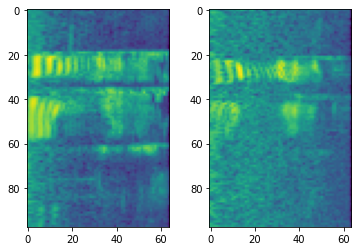

In [ ]:
fig , ax = plt.subplots(1,2)
ax[0].imshow(
    build_mel_calculation_graph(tf.constant(data1,dtype=tf.float32))[...,0]
    )
ax[1].imshow(
    build_mel_calculation_graph(tf.constant(data2,dtype=tf.float32))[...,0]
    )

In [ ]:
inpShape=(148,64,1)
model = tf.keras.applications.EfficientNetB0(include_top=False,weights=None,input_shape=inpShape)
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 148, 64, 1)] 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 148, 64, 1)   0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 148, 64, 1)   3           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 149, 65, 1)   0           normalization_1[0][0]            
_____________________________________________________________________________________

In [ ]:
def l2_reg_output(x):
  return tf.keras.backend.l2_normalize(x,axis=1)

outputLayer = model.get_layer('block4c_add').output
x = tf.keras.layers.Conv2D(32,3,padding="same",name="extra_conv1",kernel_regularizer="l2")(outputLayer)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(64,3,padding="same",name = "extra_conv2",kernel_regularizer="l2")(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(x.shape[1]//2, x.shape[2]//2), strides=None, padding="valid")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128,kernel_regularizer="l2")(x)
x = tf.keras.layers.Lambda(l2_reg_output)(x)

baseNetwork = tf.keras.Model(inputs=model.input,outputs=x,name="basemodel")
baseNetwork.summary()


In [ ]:
from tensorflow.keras import backend as K
def euclidean_distance(featsA,featsB):
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def cosine_distance(featsA:np.array,featsB:np.array):
	return tf.matmul(featsA,featsB.T)
	

In [ ]:
baseNetwork = tf.keras.models.load_model("/content/drive/MyDrive/Siamese/modelCheckpoints_old/model-8-01-0.96.h5").get_layer("basemodel")
inputLayer = tf.keras.layers.Input(shape=(2,98,64,1))

#v = 0.5 
#q = 0.1

input1 = inputLayer[:,0]
input2 = inputLayer[:,1]

output1 = baseNetwork(input1)
output2 = baseNetwork(input2)

#distance = 1 - tf.expand_dims(tf.keras.losses.cosine_similarity(output1,output2),axis=-1)
distance = euclidean_distance(output1,output2)
#Fx = ((1-v)/q)*(distance-1)+1
#Sx = (v/(2-q))*(distance+1)

#cubed = tf.math.pow(distance,3)
#threshold = 0.2
#finalOutput = 1 - (cubed/(threshold**3+cubed)) 
#finalOutput = tf.maximum(Fx,Sx)
#finalOutput = tf.cond(distance>(1-q),lambda:Fx,lambda:Sx)

siamese_model = tf.keras.Model(inputs=inputLayer,outputs=distance)
siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2, 98, 64, 1 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_4 (Sli (None, 98, 64, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_5 (Sli (None, 98, 64, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
basemodel (Functional)          (None, 128)          364183      tf.__operators__.getitem_4[0][0] 
                                                                 tf.__operators__.getitem_5[0]

In [ ]:
def triplet_loss(y_true,y_pred):
  #matchloss = -2ln(1-x/2)
  #mismatchloss = max(-ln(x/0.2),0)
  match_loss =  y_true * -2.0 * tf.math.log( 1 - y_pred/2 ) 
  mismatch_loss =  tf.maximum(
        (1 - y_true) * ( -tf.math.log(y_pred/0.2) ) ,
        0
  )

  return tf.reduce_mean( match_loss + mismatch_loss )

def accuracy(y_true ,y_pred):
  #y_true = tf.equal(y_true,1.0)
  threshold_check = tf.cast(tf.less_equal(y_pred,0.2),dtype=tf.float32)
  #matches = tf.cast(tf.equal(y_true,threshold_check),dtype=tf.float32)
  return tf.keras.metrics.binary_accuracy(y_true,threshold_check)

##Test code
t = tf.constant((1.0,1.0,1.0,1.0,1.0,1.0))
q = t - 0

print(triplet_loss(t,q))
print(accuracy(t,q))

tf.Tensor(1.3862944, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


In [ ]:
BATCH_SIZE = 64 
NUMBER_OF_EPOCHS = 15
CROSSED_NO_EPOCHS = 0

model = tf.keras.models.load_model(
    "/content/drive/MyDrive/Siamese/modelCheckpoints/model-4-15-loss_0.072_val_acc0.947.h5",
    custom_objects={"triplet_loss":triplet_loss})
#model = siamese_model

chunkedNoisePath = "/content/NoiseChunked"
        
datasetPath = "/content/dataset_format_fixed"

training_generator = CustomDataGen(chunkedNoisePath, datasetPath, batch_size = BATCH_SIZE)
test_generator = CustomDataGen(chunkedNoisePath, datasetPath, batch_size = BATCH_SIZE, training_generator=False)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/Siamese/modelCheckpoints/model-5-{epoch:02d}-loss_{loss:.3f}_val_acc{val_accuracy:.3f}.h5',
        monitor = 'val_accuracy',
        save_best_only = False
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'loss',
        factor = 0.1,
        patience = 2,
        min_lr = 1e-5
    ),
]

adam = tf.keras.optimizers.Adam(1e-5)

#To continue from lastpoint
#model = tf.keras.models.load_model("/content/drive/MyDrive/Siamese/ref_model7-1-07-0.91.h5")
#CROSSED_NO_EPOCHS = 14

model.compile(
    #loss="binary_crossentropy",
    loss = triplet_loss ,
    optimizer=adam,
	metrics=[accuracy]
)

history1 = model.fit(
    training_generator,
    epochs = 25,
    validation_data=test_generator,
    callbacks=my_callbacks)


train size:  2424
test size:  270
Epoch 1/25
75/75 [==============================] - 935s 12s/step - loss: 0.0711 - accuracy: 0.9287 - val_loss: 0.0651 - val_accuracy: 0.9453


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
75/75 [==============================] - 911s 12s/step - loss: 0.0696 - accuracy: 0.9377 - val_loss: 0.0714 - val_accuracy: 0.9297
Epoch 3/25
75/75 [==============================] - 912s 12s/step - loss: 0.0684 - accuracy: 0.9319 - val_loss: 0.0668 - val_accuracy: 0.9355
Epoch 4/25
75/75 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 0.9304 

In [ ]:
print(history1)